In [14]:
# Imports
import pickle as pic
import numpy as np
import seaborn as sb
import nltk, string
import pandas as pd
from gensim import corpora, models, similarities
from collections import defaultdict
from nltk.corpus import stopwords
import gensim
from itertools import compress
%matplotlib inline

### Prepare Data (BOW Model)

In [ ]:
# Get Text and Index
ann_text = all_data['ann_text'].values
ref_text = all_data['fragment'].values

# Define normalizer
stemmer = nltk.stem.porter.PorterStemmer()

stop = set(stopwords.words('english'))

def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens if item not in stop]

def normalize(text):
    return stem_tokens(nltk.word_tokenize(
            text.lower().translate(None, string.punctuation)))

# Normalize our annotations and Referent Text
ann_text_bow = map(normalize, ann_text)
ref_text_bow = map(normalize, ref_text)

# Get frequency dictionary
frequency = defaultdict(int)
for text in ann_text_bow:
    for token in text:
        frequency[token] += 1

# Create Dictionary with our annotations (only including words that appear more than once)
ann_text_mult = [[token for token in text if frequency[token] > 1] 
         for text in ann_text_bow]

dictionary = corpora.Dictionary(ann_text_mult)
dictionary.num_docs

# Print Number of Words in the Dictionary
len(dictionary.values())

# Create our corpus
corpus_bow = [dictionary.doc2bow(text) for text in ann_text_mult]

In [16]:
# Get Text and Index
ann_text = all_data['ann_text'].values
ref_text = all_data['fragment'].values

In [11]:
# Print first five sparse vectors in the corpus
print corpus_bow[:5]
print len(corpus_bow)

[[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)], [(1, 1), (11, 3), (13, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 3), (27, 1), (28, 1), (29, 1), (30, 2), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 2), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1), (44, 1)], [(11, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1)], [(11, 2), (50, 1), (51, 2), (52, 3), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 2), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 2), (71, 1), (72, 1), (73, 3), (74, 1), (75, 1), (76, 1), (77, 2), (78, 1)], [(2, 1), (4, 1), (10, 1), (11, 1), (13, 1), (20, 1), (71, 1), (79, 1), (80, 1), (81, 2), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 3), (96, 2), (97, 4), (98, 1), (99,

## Artist Specific Corpus
In order to limit similarity comparisons for our specified query, we need to create a dictionary of artist specific corpuses that we can compare over to subset our search space to minimzing computational expense

In [12]:
# Create dictionary for storing artist corpuses and their associated id
artist_corpus_dict = {}

# Fill dictionary with artist specific corpuses
artist_ids = all_data['artist_id'].unique()
for artist_id in artist_ids:
    id_mask = list(all_data['artist_id'] == artist_id)
    artist_text = compress(ann_text_mult, id_mask)
    artist_corpus = [dictionary.doc2bow(text) for text in artist_text]
    artist_corpus_dict[artist_id] = artist_corpus

In [13]:
artist_corpus_dict.keys()

[132097,
 2,
 3,
 4,
 5,
 1,
 1032,
 15369,
 100874,
 13,
 1039,
 1553,
 1043,
 20,
 1557,
 22,
 11353,
 47131,
 2588,
 2077,
 34,
 348422,
 42,
 555,
 556,
 45,
 46,
 1583,
 44080,
 1073,
 23090,
 241331,
 140856,
 59,
 64,
 4161,
 67,
 68,
 69,
 72,
 73,
 74,
 76,
 77,
 1102,
 82,
 83,
 24661,
 86,
 1111,
 88,
 89,
 271,
 92,
 13157,
 344,
 685,
 103,
 105,
 108,
 110,
 111,
 112,
 143985,
 115,
 464,
 119,
 448,
 123,
 1148,
 127,
 640,
 12417,
 130,
 643,
 132,
 646,
 4231,
 535,
 1181,
 147,
 148,
 2197,
 108185,
 8346,
 156,
 157,
 158,
 3781,
 161,
 170,
 1195,
 173,
 2736,
 136370,
 179,
 1205,
 182,
 183,
 186,
 3264,
 1218,
 195,
 197,
 198,
 78535,
 72393,
 202,
 330443,
 204,
 20185,
 223,
 976,
 228,
 229,
 745,
 996586,
 747,
 748,
 778477,
 7922,
 1267,
 758,
 2295,
 249,
 1274,
 251,
 554,
 255,
 185600,
 649478,
 129,
 1581,
 25560,
 276,
 47387,
 288,
 569121,
 291,
 1319,
 810,
 812,
 301,
 303,
 1001264,
 306,
 11571,
 1333,
 2358,
 1340,
 49470,
 835,
 310,
 326,
 

## TFIDF and Similarity Calculation

In [12]:
# Tf-Idf our corpus
tfidf = models.TfidfModel(corpus_bow)
corpus_tfidf = tfidf[corpus_bow]

In [127]:
corpus_tfidf[10]

[(6, 0.08616712721841321),
 (10, 0.10519935747566475),
 (11, 0.08677691690118534),
 (29, 0.0763050052291867),
 (49, 0.1743352640237535),
 (55, 0.15630402527104725),
 (70, 0.2442214808010997),
 (73, 0.13238350611339217),
 (76, 0.7162738193367085),
 (98, 0.06491888591627472),
 (263, 0.13345472212371956),
 (264, 0.17009232202834304),
 (265, 0.3132219233921482),
 (266, 0.11914502819701409),
 (267, 0.14545674756534033),
 (268, 0.1336786323420589),
 (269, 0.11696603291584631),
 (270, 0.2552351910647526),
 (271, 0.1520051676604362),
 (272, 0.11058961656188068),
 (273, 0.08164145569932593)]

In [15]:
# Create indices for querying separated by artist_id
artist_index_dict = {}
for key, value in artist_corpus_dict.iteritems():
    artist_index_dict[key] = similarities.MatrixSimilarity(tfidf[value])

In [16]:
# Randomly Sample 100 referents to compare
ref_indices = np.random.choice(range(all_data.shape[0]), 100, replace=False)

In [ ]:
# Get the index for the "correct" annotation for each referent
ref_artist_id = all_data.iloc[ref_indices[0], :]['artist_id']
ref_ann_id = all_data.iloc[ref_indices[0], :]['ann_id']
artist_df = all_data[all_data['artist_id'] == ref_artist_id].reset_index(drop=True)
index = artist_df[artist_df['ann_id'] == ref_ann_id].index[0]
index

In [ ]:
# Create TDIDF representation of our test query (referent)
doc = ref_text_bow[ref_indices[0]]
doc_bow = dictionary.doc2bow(doc)
doc_tfidf = tfidf[doc_bow]

# Query our index for closely related documents
sims_tfidf = artist_index_dict[ref_artist_id][doc_tfidf]
sims_tfidf = sorted(enumerate(sims_tfidf), 
                    key=lambda item: item[1], reverse=True)
sims_tfidf = np.array(sims_tfidf)
sims_tfidf[4][:]

In [17]:
# Create Function for calucating TFIDF searcha accuracy
def search_accuracy_tfidf(index):
    ref_artist_id = all_data.iloc[index, :]['artist_id']
    ref_ann_id = all_data.iloc[index, :]['ann_id']
    artist_df = all_data[all_data['artist_id'] == ref_artist_id].reset_index(drop=True)
    ref_position = artist_df[artist_df['ann_id'] == ref_ann_id].index[0]
    doc = ref_text_bow[index]
    doc_bow = dictionary.doc2bow(doc)
    doc_tfidf = tfidf[doc_bow]
    print doc_tfidf
    sims_tfidf = artist_index_dict[ref_artist_id][doc_tfidf]
    sims_tfidf = sorted(enumerate(sims_tfidf), 
                        key=lambda item: item[1], reverse=True)
    sims_tfidf = np.array(sims_tfidf)
    correct_position = np.where(sims_tfidf[:, 0] == ref_position)[0][0]
    percentile = 1 - correct_position/float(sims_tfidf.shape[0])
    return correct_position, percentile

In [18]:
scores = []
for idx in ref_indices:
    print idx
    accuracy = search_accuracy_tfidf(idx)
    scores.append(accuracy)

50888
[(4, 0.079370335248297), (27, 0.10072152860896998), (83, 0.16971580360208702), (85, 0.13779271034689036), (436, 0.1913632995573451), (438, 0.13466412582417508), (619, 0.4201503976903296), (691, 0.13061177328778079), (1285, 0.12383878842109806), (1687, 0.17263681354120147), (2672, 0.21699039284056174), (3399, 0.2061870919675847), (4430, 0.26836795546246284), (5221, 0.29565780067639197), (5913, 0.30346696750863505), (13891, 0.34082598769883476), (23706, 0.43011416632322685)]
34177
[(2, 0.07104873556955503), (290, 0.10279858974383073), (545, 0.20420345657190062), (704, 0.1339839753619566), (1823, 0.19527998582116018), (2458, 0.15587609636197367), (3786, 0.25368179109635713), (4006, 0.2222088515576143), (4270, 0.23563227570037465), (4818, 0.23116231842037896), (6176, 0.2512892090809866), (11127, 0.3202067721832947), (12254, 0.30910392407885), (14209, 0.3988119098472773), (14779, 0.26822313246098584), (19809, 0.3839190802775997)]
63751
[(59, 0.2744513850402358), (164, 0.19054772955554

## Latent Semantic Analysis and Similarity Calcuation

In [37]:
# Create Function for calucating TFIDF search accurracy
def search_accuracy_lsa(lsa_model, artist_index_dict, index):
    ref_artist_id = all_data.iloc[index, :]['artist_id'] # Find referent artist id
    ref_ann_id = all_data.iloc[index, :]['ann_id'] # Find referent annotation id
    artist_df = all_data[all_data['artist_id'] == ref_artist_id].reset_index(drop=True) # Subset data on the specific artist
    ref_position = artist_df[artist_df['ann_id'] == ref_ann_id].index[0] # Find referent index in artist df
    doc = ref_text_bow[index] # Get referent as a bow
    doc_bow = dictionary.doc2bow(doc)
    doc_lsa = lsa_model[tfidf[doc_bow]] # Project Referent in LSA space
    sims_lsa = artist_index_dict[ref_artist_id][doc_lsa] # Calculate similarities amongst annotations
    sims_lsa = sorted(enumerate(sims_lsa), 
                        key=lambda item: item[1], reverse=True)
    sims_lsa = np.array(sims_lsa)
    correct_position = np.where(sims_lsa[:, 0] == ref_position)[0][0] # Find Ranking Position of correct annotation
    percentile = 1 - correct_position/float(sims_lsa.shape[0]) # Find Percentile Ranking
    return correct_position, percentile

In [61]:
# Create Function for Generating LSA Scores Based on our Sample
def gen_scores(lsa_model, artist_index_dict, idx_list):
    scores = []
    for idx in idx_list:
        accuracy = search_accuracy_lsa(lsa_model, artist_index_dict, idx)
        scores.append(accuracy)
    scores = np.array(scores)
    return scores

In [108]:
def top_n_accuracy(rankings, n):
    num_correct = sum(rankings <= n)
    return  float(num_correct) / len(rankings)

In [56]:
# Randomly Sample 1000 referents to compare
ref_indices = np.random.choice(range(all_data.shape[0]), 1000, replace=False)

### 10 Topics

In [35]:
# LSA our Tf-Idf corpus with 10 topics
lsa_10 = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=10)
corpus_lsa = lsa_10[corpus_tfidf]

# Create indices for querying by artist
artist_lsa_index_dict_10 = {}
for key, value in artist_corpus_dict.iteritems():
    artist_lsa_index_dict_10[key] = similarities.MatrixSimilarity(lsa_10[tfidf[value]])

In [131]:
corpus_lsa[750]

[(0, 0.022240936389140462),
 (1, -0.027558728407065532),
 (2, 0.0059030163067693986),
 (3, 0.0042748297768546517),
 (4, 0.0014107640041380657),
 (5, 0.0023620006103712041),
 (6, 0.012548787772103432),
 (7, -0.0051443585647184681),
 (8, 0.0016854071868703782),
 (9, -0.0073788388547801663)]

In [62]:
# Generate Scores
scores_lsa_10 = gen_scores(lsa_10, artist_lsa_index_dict_10, ref_indices)

In [109]:
top_n_accuracy(scores_lsa_10[:,0], 5)

0.062

In [110]:
# Print Average Ranking and Average Percentile for LSA with 10 Topics
av_rank = np.mean(scores_lsa_10[:, 0])
median_rank = np.median(scores_lsa_10[:, 0])
av_percentile = np.mean(scores_lsa_10[:, 1])
median_percentile = np.median(scores_lsa_10[:, 1])
top_5_accuracy = top_n_accuracy(scores_lsa_10[:, 0], 5)
top_10_accuracy = top_n_accuracy(scores_lsa_10[:, 0], 10)
print "Average Rank: %s" % av_rank
print "Average Percentile: %s" % av_percentile
print "Median Rank: %s" % median_rank
print "Median Percentile: %s" % median_percentile
print "Top 5 Accuracy: %s" % top_5_accuracy
print "Top 10 Accuracy: %s" % top_10_accuracy

Average Rank: 2093.969
Average Percentile: 0.620451158967
Median Rank: 686.5
Median Percentile: 0.657974742848
Top 5 Accuracy 0.062
Top 10 Accuracy 0.081


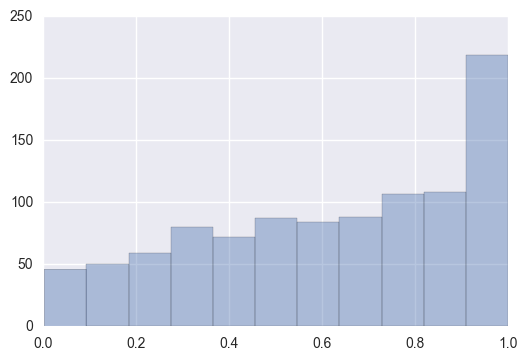

In [67]:
# Plot Percentiles
sb.distplot(scores_lsa_10[:, 1], kde=False)

### 50 Topics

In [70]:
# LSA our Tf-Idf corpus with 10 topics
lsa_50 = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=50)

# Create indices for querying by artist
artist_lsa_index_dict_50 = {}
for key, value in artist_corpus_dict.iteritems():
    artist_lsa_index_dict_50[key] = similarities.MatrixSimilarity(lsa_50[tfidf[value]])

In [71]:
# Generate Scores
scores_lsa_50 = gen_scores(lsa_50, artist_lsa_index_dict_50, ref_indices)

In [113]:
# Print Average Ranking and Average Percentile for LSA with 50 Topics
av_rank = np.mean(scores_lsa_50[:, 0])
median_rank = np.median(scores_lsa_50[:, 0])
av_percentile = np.mean(scores_lsa_50[:, 1])
median_percentile = np.median(scores_lsa_50[:, 1])
top_5_accuracy = top_n_accuracy(scores_lsa_50[:, 0], 5)
top_10_accuracy = top_n_accuracy(scores_lsa_50[:, 0], 10)
print "Average Rank: %s" % av_rank
print "Average Percentile: %s" % av_percentile
print "Median Rank: %s" % median_rank
print "Median Percentile: %s" % median_percentile
print "Top 5 Accuracy: %s" % top_5_accuracy
print "Top 10 Accuracy: %s" % top_10_accuracy

Average Rank: 1473.652
Average Percentile: 0.728940052564
Median Rank: 352.5
Median Percentile: 0.840482206469
Top 5 Accuracy: 0.113
Top 10 Accuracy: 0.148


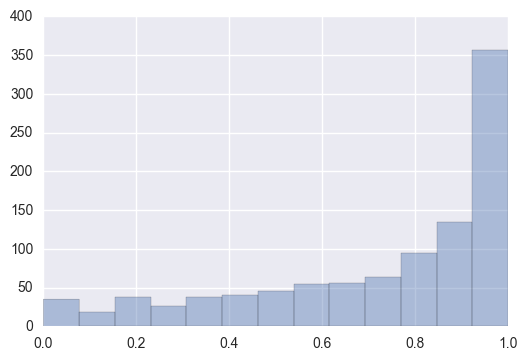

In [73]:
# Plot Percentiles
sb.distplot(scores_lsa_50[:, 1], kde=False)

### 100 Topics

In [74]:
# LSA our Tf-Idf corpus with 100 topics
lsa_100 = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=100)

# Create indices for querying by artist
artist_lsa_index_dict_100 = {}
for key, value in artist_corpus_dict.iteritems():
    artist_lsa_index_dict_100[key] = similarities.MatrixSimilarity(lsa_100[tfidf[value]])

In [75]:
# Generate Scores
scores_lsa_100 = gen_scores(lsa_100, artist_lsa_index_dict_100, ref_indices)

In [112]:
# Print Average Ranking and Average Percentile for LSA with 500 Topics
av_rank = np.mean(scores_lsa_100[:, 0])
median_rank = np.median(scores_lsa_100[:, 0])
av_percentile = np.mean(scores_lsa_100[:, 1])
median_percentile = np.median(scores_lsa_100[:, 1])
top_5_accuracy = top_n_accuracy(scores_lsa_100[:, 0], 5)
top_10_accuracy = top_n_accuracy(scores_lsa_100[:, 0], 10)
print "Average Rank: %s" % av_rank
print "Average Percentile: %s" % av_percentile
print "Median Rank: %s" % median_rank
print "Median Percentile: %s" % median_percentile
print "Top 5 Accuracy: %s" % top_5_accuracy
print "Top 10 Accuracy: %s" % top_10_accuracy

Average Rank: 1273.422
Average Percentile: 0.76724782372
Median Rank: 218.5
Median Percentile: 0.900306716356
Top 5 Accuracy: 0.152
Top 10 Accuracy: 0.196


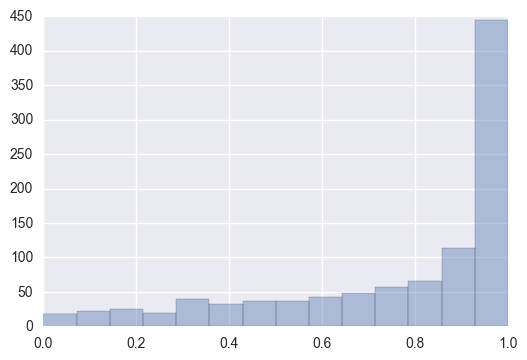

In [77]:
# Plot Percentiles
sb.distplot(scores_lsa_100[:, 1], kde=False)

### 500 Topics

In [79]:
# LSA our Tf-Idf corpus with 100 topics
lsa_500 = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=500)

# Create indices for querying by artist
artist_lsa_index_dict_500 = {}
for key, value in artist_corpus_dict.iteritems():
    artist_lsa_index_dict_500[key] = similarities.MatrixSimilarity(lsa_500[tfidf[value]])

In [80]:
# Generate Scores
scores_lsa_500 = gen_scores(lsa_500, artist_lsa_index_dict_500, ref_indices)

In [111]:
# Print Average Ranking and Average Percentile for LSA with 500 Topics
av_rank = np.mean(scores_lsa_500[:, 0])
median_rank = np.median(scores_lsa_500[:, 0])
av_percentile = np.mean(scores_lsa_500[:, 1])
median_percentile = np.median(scores_lsa_500[:, 1])
top_5_accuracy = top_n_accuracy(scores_lsa_500[:, 0], 5)
top_10_accuracy = top_n_accuracy(scores_lsa_500[:, 0], 10)
print "Average Rank: %s" % av_rank
print "Average Percentile: %s" % av_percentile
print "Median Rank: %s" % median_rank
print "Median Percentile: %s" % median_percentile
print "Top 5 Accuracy: %s" % top_5_accuracy
print "Top 10 Accuracy: %s" % top_10_accuracy

Average Rank: 813.907
Average Percentile: 0.854596183081
Median Rank: 52.5
Median Percentile: 0.976158405442
Top 5 Accuracy: 0.274
Top 10 Accuracy: 0.332


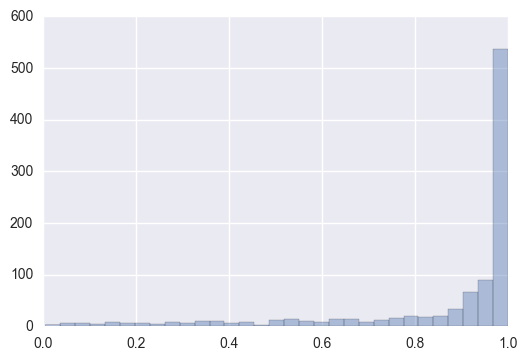

In [82]:
# Plot Percentiles
sb.distplot(scores_lsa_500[:, 1], kde=False)

## Latent Dirichlet Allocation and Similarity Calculation

In [84]:
# Create Function for calculating LDA search accurracy
def search_accuracy_lda(lda_model, artist_index_dict, index):
    ref_artist_id = all_data.iloc[index, :]['artist_id'] # Find referent artist id
    ref_ann_id = all_data.iloc[index, :]['ann_id'] # Find referent annotation id
    artist_df = all_data[all_data['artist_id'] == ref_artist_id].reset_index(drop=True) # Subset data on the specific artist
    ref_position = artist_df[artist_df['ann_id'] == ref_ann_id].index[0] # Find referent index in artist df
    doc = ref_text_bow[index] # Get referent as a bow
    doc_bow = dictionary.doc2bow(doc)
    doc_lda = lda_model[doc_bow] # Project Referent in LDA space
    sims_lda = artist_index_dict[ref_artist_id][doc_lda] # Calculate similarities amongst annotations
    sims_lda = sorted(enumerate(sims_lda), 
                        key=lambda item: item[1], reverse=True)
    sims_lda = np.array(sims_lda)
    correct_position = np.where(sims_lda[:, 0] == ref_position)[0][0] # Find Ranking Position of correct annotation
    percentile = 1 - correct_position/float(sims_lda.shape[0]) # Find Percentile Ranking
    return correct_position, percentile

In [85]:
# Create Function for Generating LDA Scores Based on our Sample
def gen_lda_scores(lda_model, artist_index_dict, idx_list):
    scores = []
    for idx in idx_list:
        accuracy = search_accuracy_lda(lda_model, artist_index_dict, idx)
        scores.append(accuracy)
    scores = np.array(scores)
    return scores

### 10 Topics

In [13]:
lda_10 = models.LdaModel(corpus_bow, id2word=dictionary, num_topics=10)

In [88]:
# LDA our BOW corpus (10 Topics)
lda_10 = models.LdaModel(corpus_bow, id2word=dictionary, num_topics=10)

# Create indices for querying by artist
artist_lda_index_dict_10 = {}
for key, value in artist_corpus_dict.iteritems():
    artist_lda_index_dict_10[key] = similarities.MatrixSimilarity(lda_10[value])

In [25]:
lda_10.bound(corpus_bow)

-23874375.08008334

In [89]:
# Generate Scores
scores_lda_10 = gen_lda_scores(lda_10, artist_lda_index_dict_10, ref_indices)

In [114]:
# Print Average Ranking and Average Percentile for LDA with 10 Topics
av_rank = np.mean(scores_lda_10[:, 0])
median_rank = np.median(scores_lda_10[:, 0])
av_percentile = np.mean(scores_lda_10[:, 1])
median_percentile = np.median(scores_lda_10[:, 1])
top_5_accuracy = top_n_accuracy(scores_lda_10[:, 0], 5)
top_10_accuracy = top_n_accuracy(scores_lda_10[:, 0], 10)
print "Average Rank: %s" % av_rank
print "Average Percentile: %s" % av_percentile
print "Median Rank: %s" % median_rank
print "Median Percentile: %s" % median_percentile
print "Top 5 Accuracy: %s" % top_5_accuracy
print "Top 10 Accuracy: %s" % top_10_accuracy

Average Rank: 1772.354
Average Percentile: 0.676936334855
Median Rank: 569.5
Median Percentile: 0.75502047847
Top 5 Accuracy: 0.068
Top 10 Accuracy: 0.092


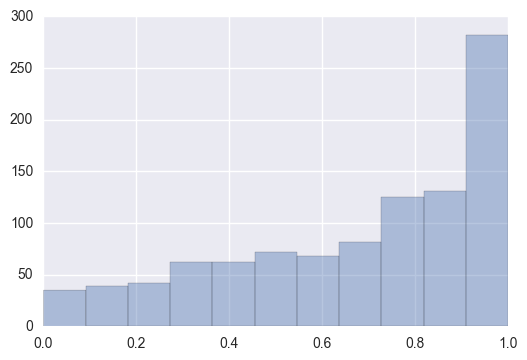

In [91]:
# Plot Percentiles
sb.distplot(scores_lda_10[:, 1], kde=False)

In [23]:
# LDAvis
import pyLDAvis.gensim
import pyLDAvis

lda_10_vis = pyLDAvis.gensim.prepare(lda_10, corpus_bow, dictionary)

In [24]:
pyLDAvis.display(lda_10_vis)

### 50 Topics

In [117]:
# LDA our BOW corpus
lda_50 = models.LdaModel(corpus_bow, id2word=dictionary, num_topics=50)

# Create indices for querying by artist
artist_lda_index_dict_50 = {}
for key, value in artist_corpus_dict.iteritems():
    artist_lda_index_dict_50[key] = similarities.MatrixSimilarity(lda_50[value])

In [118]:
# Generate Scores
scores_lda_50 = gen_lda_scores(lda_50, artist_lda_index_dict_50, ref_indices)

In [121]:
# Print Average Ranking and Average Percentile for LSA with 50 Topics
av_rank = np.mean(scores_lda_50[:, 0])
median_rank = np.median(scores_lda_50[:, 0])
av_percentile = np.mean(scores_lda_50[:, 1])
median_percentile = np.median(scores_lda_50[:, 1])
top_5_accuracy = top_n_accuracy(scores_lda_50[:, 0], 5)
top_10_accuracy = top_n_accuracy(scores_lda_50[:, 0], 10)
print "Average Rank: %s" % av_rank
print "Average Percentile: %s" % av_percentile
print "Median Rank: %s" % median_rank
print "Median Percentile: %s" % median_percentile
print "Top 5 Accuracy: %s" % top_5_accuracy
print "Top 10 Accuracy: %s" % top_10_accuracy

Average Rank: 1469.389
Average Percentile: 0.727235174031
Median Rank: 294.0
Median Percentile: 0.847116371119
Top 5 Accuracy: 0.096
Top 10 Accuracy: 0.131


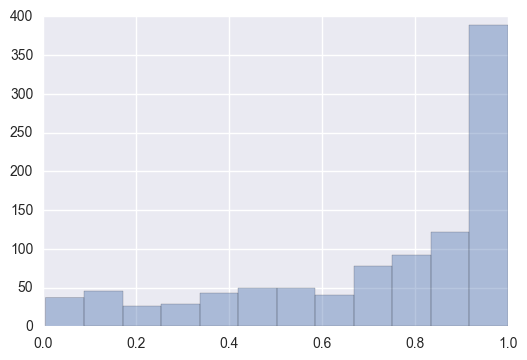

In [122]:
# Plot Percentiles
sb.distplot(scores_lda_50[:, 1], kde=False)

### 100 Topics

In [123]:
# LDA our BOW corpus
lda_100 = models.LdaModel(corpus_bow, id2word=dictionary, num_topics=100)

# Create indices for querying by artist
artist_lda_index_dict_100 = {}
for key, value in artist_corpus_dict.iteritems():
    artist_lda_index_dict_50[key] = similarities.MatrixSimilarity(lda_100[value])

In [124]:
# Generate Scores
scores_lda_100 = gen_lda_scores(lda_100, artist_lda_index_dict_100, ref_indices)

KeyError: 59

In [ ]:
# Print Average Ranking and Average Percentile for LSA with 50 Topics
av_rank = np.mean(scores_lda_100[:, 0])
median_rank = np.median(scores_lda_100[:, 0])
av_percentile = np.mean(scores_lda_100[:, 1])
median_percentile = np.median(scores_lda_100[:, 1])
top_5_accuracy = top_n_accuracy(scores_lda_100[:, 0], 5)
top_10_accuracy = top_n_accuracy(scores_lda_100[:, 0], 10)
print "Average Rank: %s" % av_rank
print "Average Percentile: %s" % av_percentile
print "Median Rank: %s" % median_rank
print "Median Percentile: %s" % median_percentile
print "Top 5 Accuracy: %s" % top_5_accuracy
print "Top 10 Accuracy: %s" % top_10_accuracy

In [ ]:
# Plot Percentiles
sb.distplot(scores_lda_50[:, 1], kde=False)

In [26]:
import time

In [37]:
start = time.time()

In [38]:
end = time.time() - start

In [39]:
end

8.30180311203003

In [49]:
d = {5: ([3,5,7], 5),
    10: ([2,3,4], 3),
    11: ([3,4,5], 4)}